In [62]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

## Bangla Digit Dataset
Bangla digit dataset is available from https://www.kaggle.com/c/numta.

In [63]:
threshold = 160
binarizer = lambda x : 255 if x > threshold else 0

In [64]:
# Load train and test data from CSV files.
train = pd.read_csv("numta/training-a.csv", header=0)

length = len(train.index)
width = 180
height = 180

train_x = np.zeros(shape=(length, width * height), dtype=int)

i = 0
for row in train.itertuples():
    filepath = 'numta/training-a/' + row.filename
    img = Image.open(filepath).convert("L").point(binarizer, mode='1')
    train_x[i] = np.array(img, dtype=int).ravel()
    i += 1

In [69]:
train_y = train['digit']
print(train_y.value_counts().sort_index())

0    1975
1    1963
2    1984
3    1976
4    1982
5    1965
6    1983
7    1960
8    1950
9    1964
Name: digit, dtype: int64


In [66]:
files = os.listdir('numta/testing-a/')
m = len(files)

test_x = np.zeros((m, width * height), dtype = "float32")

i = 0;
for file in files:
    img = Image.open('numta/testing-a/' + file).convert("L").point(binarizer, mode='1')
    test_x[i] = np.asarray(img, dtype=int).ravel()
    i += 1

Here we define two helper functions which plot the image of an instance for data exploration and debugging.

In [60]:
def plot_digit(x, y, width=180, height=180):
    """
    Plot a single image
    """
    plt.imshow(np.reshape(x, (width, height)), cmap='gray')
    plt.title('Digit Label: {}'.format(y))
    plt.show()

In [58]:
def plot_digits(x, y, width=180, height=180):
    """
    Plot the image of the digits
    """
    plt.clf()
    plt.style.use('seaborn-muted')

    fig, axes = plt.subplots(
        3, 3, 
        figsize=(5, 5),
        sharex=True,
        sharey=True,
        subplot_kw=dict(adjustable='box', aspect='equal'))

    for i in range(0, 9):
        # Idnetify the subgraph given class i.
        subplot_row = i // 3 
        subplot_col = i % 3 
        ax = axes[subplot_row, subplot_col]

        # Plot image on subplot.
        ax.imshow(np.reshape(x[i], (width, height)), cmap='gray')

        ax.set_title('Digit Label: {}'.format(y[i]))
        ax.set_xbound([0, height])

    plt.tight_layout()
    plt.show()

### Plot a single image in the dataset

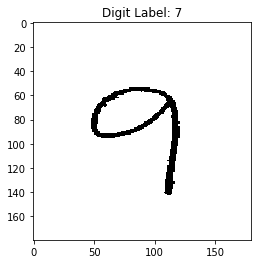

In [70]:
plot_digit(train_x[3], train_y[3])

### View the digit images from class 1 to 9.

To better understand the dataset, we plot the first occurence of each class (1-9) in the train dataset using the grayscale inputs.

In the following code, we plot nine images of digits 0 in the train dataset. 

<Figure size 432x288 with 0 Axes>

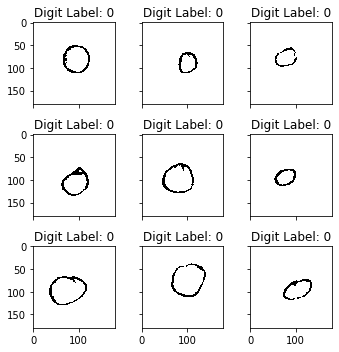

In [72]:
# Find the first 9 occurrences of digit zero in the train dataset
zero_digit_idx = list(train_y[train_y == 0].index[0:9])

# Plot digits
plot_digits(train_x[zero_digit_idx], train_y[zero_digit_idx].values)

### Plot the first image of digits 1 to 9 in the training dataset

<Figure size 432x288 with 0 Axes>

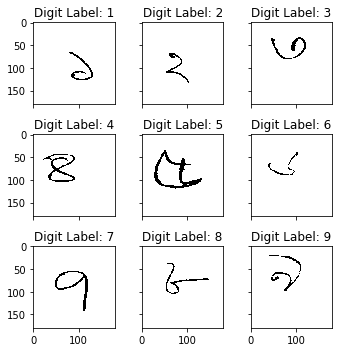

In [73]:
# Find the first occurrence of each class in the train dataset
idx = [-1] * 9
for i in range(1, 10):
  # Find the first image from the class i.
  idx[i-1] = train_y[train_y == i].index[0]

# Plot digits
plot_digits(train_x[idx], train_y[idx].values)

In [74]:
train_y = train_y.to_numpy()

---

### Classify

In [5]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.applications import HyperResNet

In [7]:
def build_model(hp):
    model = keras.Sequential()

    for layer in range(hp.Int("layers", min_value = 1, max_value = 4, step = 1)):
        model.add(layers.Dense(
            units = hp.Int(
                "units_" + str(layer),
                min_value = 32,
                max_value = 512,
                step = 32),
            activation = "relu"))
        
        model.add(layers.Dropout(
            hp.Float(
                "dropout",
                0,
                0.5,
                step = 0.1)))

    model.add(layers.Dense(10, activation = "softmax"))
    model.compile(
        optimizer = keras.optimizers.Adam(
            hp.Choice(
                "learning_rate",
                values = [1e-2, 1e-3, 1e-4])
            ),
        loss = "sparse_categorical_crossentropy",
        metrics =[ "accuracy" ])

    return model

In [8]:
tuner = BayesianOptimization(build_model,
            objective = "val_loss",
            max_trials = 32,
            num_initial_points = 8,
            directory = "tuning",
            project_name = "bayesi")

In [9]:
tuner.search_space_summary()

In [ ]:
tuner.search(
    train_x,
    train_y,
    batch_size = 1024,
    epochs = 30,
    validation_split = 0.1,
    callbacks = [
        callbacks.ReduceLROnPlateau(
            monitor = "val_loss",
            patience = 2),
        callbacks.EarlyStopping(
            monitor = "val_loss",
            patience = 4,
            restore_best_weights = True) ])

In [47]:
tuner.results_summary()

In [32]:
model = tuner.get_best_models(num_models = 1)[0]

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  15552480  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  215488    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  4490      
Total params: 15,772,458
Trainable params: 15,772,458
Non-trainable params: 0
_________________________________________________________________


In [40]:
hyperparameters = tuner.get_best_hyperparameters(num_trials = 1)[0].get_config()

print(hyperparameters["values"])

{'layers': 2, 'units_0': 480, 'dropout': 0.1, 'learning_rate': 0.0001, 'units_1': 448, 'units_2': 224, 'units_3': 224}


In [ ]:
probabilities = model.predict(test_x)
test_y = model.predict_classes(test_x)

In [42]:
predictions = open("predictions-baysian6.csv", "w")

predictions.write("id,prob0,prob1,prob2,prob3,prob4,prob5,prob6,prob7,prob8,prob9\n")

for i in range(test_x.shape[0]):
    predictions.write(str(i).zfill(5) + "," + ",".join([ str(p) for p in probabilities[i] ]) + "\n")

predictions.close()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  15552480  
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  215488    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  4490      
Total params: 15,772,458
Trainable params: 15,772,458
Non-trainable params: 0
_________________________________________________________________


In [45]:
preds = open("pred-b.csv", "w")

preds.write("id,pred\n")

for i in range(test_x.shape[0]):
    preds.write(str(i).zfill(5) + "," + str(test_y[i]) + "\n")

preds.close()